In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import camb
import Corrfunc.theory.xi 
import statistics

In [2]:
# data_off = '/pscratch/sd/l/lflores/ASTRID/data/spectra_ASTRID_self-shield_off_z2.5_500x500x2500.hdf5'  # Without self-shielding
data_on = '/pscratch/sd/l/lflores/ASTRID/data/spectra_ASTRID_z2.5_500x500x2500.hdf5'  # With self-shielding

with h5py.File(data_on, 'r') as f:
    print('Keys:', f.keys())
    header_on = f['Header']
    print('------ Header ------')
    for attr in header_on.attrs:
            print(f"{attr} : {header_on.attrs[attr]}")
    print('------ Data ------')
    colden = f['colden/H/1'][:]
    print('colden shape:', colden.shape)  

Keys: <KeysViewHDF5 ['Header', 'colden', 'spectra', 'tau']>
------ Header ------
Hz : 252.87249366801257
box : 250000.0
discarded : 0
hubble : 0.6774
nbins : 2500
npart : [165988309584 166375000000            0            0  10297622146
     11325619]
omegab : 0.0486
omegal : 0.6911
omegam : 0.3089
redshift : 2.499999947500001
------ Data ------
colden shape: (250000, 2500)


In [3]:
print('----- Useful information -----')
Lbox = 250  # Mpc/h
print('box size:', Lbox, 'Mpc/h')

# Number of skewers per side
Nsk = int(np.sqrt(colden.shape[0]))  # colden.on_shape[0] gives the size of the axis
print(Nsk,'skewers per side')

# Number of pixels per skewer
Np = colden.shape[1] # colden.on_shape[1] gives the size of the columns
print(Np, 'pixels per skewer')

# Pixel width 
Pw = Lbox/Np  # Mpc/h 
print(Pw, 'Mpc/h pixel width')
# We are dividing the total box width in comoving units by the number of pixels in each skewer

# Minimum separation between skewers
Ssk = Lbox/Nsk  # Mpc/h 
print(Ssk, 'Mpc/h skewer separation')
# We are dividing the total box width in comoving units by the number of skewers per side

----- Useful information -----
box size: 250 Mpc/h
500 skewers per side
2500 pixels per skewer
0.1 Mpc/h pixel width
0.5 Mpc/h skewer separation


# Dark matter

As we will need both the power spectra and the 2pcf for dm, let's calculate them first

In [4]:
from camb import model
hubble, z = 0.6774, 2.5
omegab, omegam = 0.0486, 0.3089  # Using ASTRID simulation parameters
pars = camb.set_params(H0=100*hubble, ombh2=omegab*(hubble**2), omch2=omegam*(hubble**2), ns=0.96)

## Isotropic power spectrum

In [5]:
pars.set_matter_power(redshifts=[z], kmax=100)
pars.NonLinear = model.NonLinear_none  # Linear spectra
results = camb.get_results(pars)
k_dm, z, pk = results.get_linear_matter_power_spectrum(hubble_units=True, k_hunit=True) 
p_dm = pk[0, :]

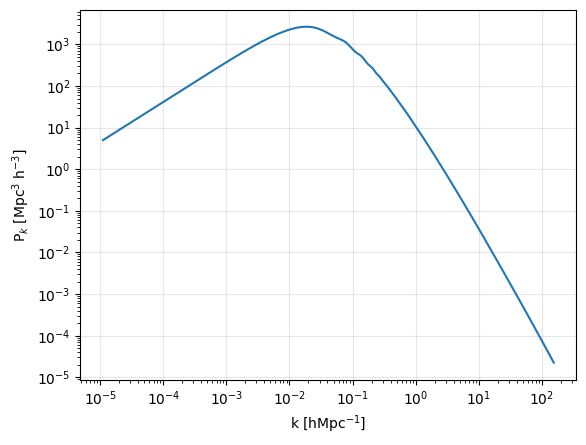

In [21]:
plt.plot(k_dm, p_dm)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k [hMpc$^{-1}$]')
plt.ylabel(r'P$_k$ [Mpc$^{3}$ h$^{-3}$]')
plt.grid(alpha=0.3);

## Correlation function

In [7]:
k_dm_logspace = np.logspace(np.log10(1e-3), np.log10(k_dm.max()), 100*len(k_dm))
p_dm_logspace = np.interp(k_dm_logspace, k_dm, p_dm)  # To improve the quality of the correlation function

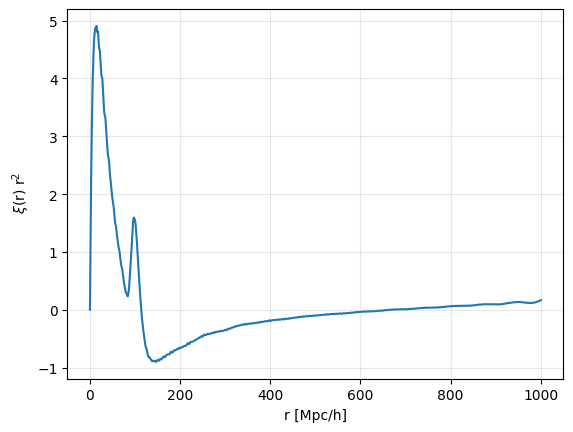

In [8]:
import hankl
r_dm, dm_2pcf = np.real(hankl.P2xi(k_dm_logspace, p_dm_logspace, l=0))

plt.plot(r_dm, (r_dm**2)*dm_2pcf)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r' $\xi$(r) r$^2$')
plt.grid(alpha=0.3);

# ASTRID data

## HCDs correlation function

In [9]:
colden[colden<=0] = np.nan  # To avoid problems with logarithms
colden_log = np.log10(colden)
colden_log.shape
del colden

For the Corrfunc function we need to input the coordinates of the HCDs in the same units as the Lbox

In [10]:
def coord_Mpc_h(colden, colden_min, colden_max, h=0.7, h_units=True):
    """ This functions gives back the coordinates (in Mpc/h if h_units=True) of those systems with a value
    of column density such as colden_min < colden < colden_max

    Parameters:
    ----------------
    colden : narray
        (Log10) Column density values of the simulation box
    colden_min : value
        Lowest limit on (log10) column density values to be considered
    colden_max : value
        Highest limit on (log10) column density values to be considered
    h : value
        Little Hubble constant value
    h_units : Boolean
        Wether we want the returned coordinates to be in units of h or not. By default, True.

    Returns:
    ---------------
    x, y, z : arrays
        Coordinate values in Mpc/h of pixels with column density within the defined range

    """

    Lbox = 250  # Mpc/h
    Nsk, Np = 500, 2500  # Number of skewers in box and number of pixels in each skewer
    Pw = Lbox/Np  # Pixel width in Mpc/h
    Skw = Lbox/Nsk  # Skewer "width" in Mpc/h 
    
    mask = (colden > colden_min) & (colden < colden_max) 
    skewer_idx, z_idx = np.where(mask)
    x_idx = skewer_idx % Nsk  # % Returns remainder of division 
    y_idx = skewer_idx // Nsk  # // Returns floor of division result (largest integer that is less than or equal to the result of the division)

    x = (x_idx + 0.5) * Skw
    y = (y_idx + 0.5) * Skw
    z = (z_idx + Pw/2) * Pw

    if h_units == False:
        x *= h
        y *= h
        z *= h

    return x, y, z

In [11]:
binf = np.linspace(0.1, 30, 30)

# HCDs
x_hcd, y_hcd, z_hcd = coord_Mpc_h(colden_log, 17.22, 22, h=hubble, h_units=True)  # Mpc/h
print(len(x_hcd), '(', len(x_hcd)/(Nsk*Nsk*Np)*100, ') %')
corrfunc_hcd = Corrfunc.theory.xi(boxsize=Lbox, nthreads=1, binfile=binf, X=x_hcd,Y=y_hcd,Z=z_hcd, output_ravg=True)
del x_hcd, y_hcd, z_hcd  # Takes too much space

# LLSs
x_lls, y_lls, z_lls = coord_Mpc_h(colden_log, 17.2, 20, h=hubble, h_units=True)  # Mpc/h
print(len(x_lls), '(', len(x_lls)/(Nsk*Nsk*Np)*100, ') %')
corrfunc_lls = Corrfunc.theory.xi(boxsize=Lbox, nthreads=1, binfile=binf, X=x_lls,Y=y_lls,Z=z_lls, output_ravg=True)
del x_lls, y_lls, z_lls

# subDLAs
x_subdla, y_subdla, z_subdla = coord_Mpc_h(colden_log, 20, 20.3, h=hubble, h_units=True)  # Mpc/h
print(len(x_subdla), '(', len(x_subdla)/(Nsk*Nsk*Np)*100, ') %')
corrfunc_subdla = Corrfunc.theory.xi(boxsize=Lbox, nthreads=1, binfile=binf, X=x_subdla,Y=y_subdla,Z=z_subdla, output_ravg=True)
del x_subdla, y_subdla, z_subdla

# small DLAs
x_smalldla, y_smalldla, z_smalldla = coord_Mpc_h(colden_log, 20.3, 21, h=hubble, h_units=True)  # Mpc/h
print(len(x_smalldla), '(', len(x_smalldla)/(Nsk*Nsk*Np)*100, ') %')
corrfunc_smalldla = Corrfunc.theory.xi(boxsize=Lbox, nthreads=1, binfile=binf, X=x_smalldla,Y=y_smalldla,Z=z_smalldla, output_ravg=True)
del x_smalldla, y_smalldla, z_smalldla

# large DLAs
x_largedla, y_largedla, z_largedla = coord_Mpc_h(colden_log, 21, 22, h=hubble, h_units=True)  # Mpc/h
print(len(x_largedla), '(', len(x_largedla)/(Nsk*Nsk*Np)*100, ') %')
corrfunc_largedla = Corrfunc.theory.xi(boxsize=Lbox, nthreads=1, binfile=binf, X=x_largedla,Y=y_largedla,Z=z_largedla, output_ravg=True)
del x_largedla, y_largedla, z_largedla

246993 ( 0.03951888 ) %
214764 ( 0.03436224 ) %
7762 ( 0.0012419199999999999 ) %
14786 ( 0.0023657599999999997 ) %
13901 ( 0.00222416 ) %


In [12]:
dm_2pcf_interp = np.interp(corrfunc_hcd['ravg'], r_dm, dm_2pcf)

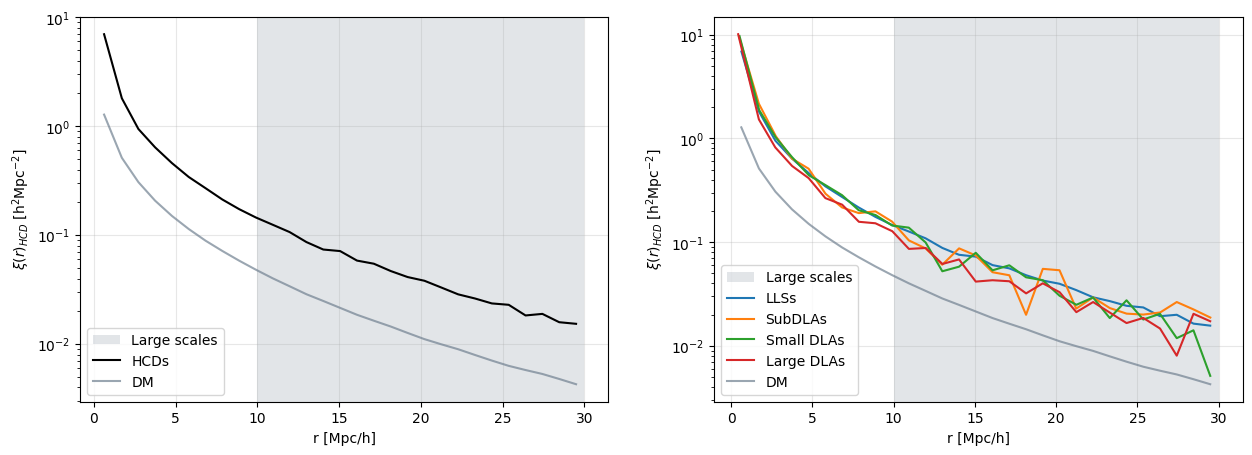

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.axvspan(10, 30, facecolor='slategrey', alpha=0.2, label='Large scales')
plt.plot(corrfunc_hcd['ravg'], corrfunc_hcd['xi'], color='k', label='HCDs')
plt.plot(corrfunc_hcd['ravg'], dm_2pcf_interp, color='slategrey', alpha=0.7, label='DM')
plt.yscale('log')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$\xi(r)_{HCD}$ [h$^2$Mpc$^{-2}$]')
plt.grid(alpha=0.3)
plt.legend();

plt.subplot(1, 2, 2)
plt.axvspan(10, 30, facecolor='slategrey', alpha=0.2, label='Large scales')
plt.plot(corrfunc_lls['ravg'], corrfunc_lls['xi'], label='LLSs')
plt.plot(corrfunc_subdla['ravg'], corrfunc_subdla['xi'], label='SubDLAs')
plt.plot(corrfunc_smalldla['ravg'], corrfunc_smalldla['xi'], label='Small DLAs')
plt.plot(corrfunc_largedla['ravg'], corrfunc_largedla['xi'], label='Large DLAs')
plt.plot(corrfunc_hcd['ravg'], dm_2pcf_interp, color='slategrey', alpha=0.7, label='DM')
plt.yscale('log')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$\xi(r)_{HCD}$ [h$^2$Mpc$^{-2}$]')
plt.grid(alpha=0.3)
plt.legend();

### Bias

In [14]:
ratio_hcd = corrfunc_hcd['xi']/dm_2pcf_interp
ratio_lls = corrfunc_lls['xi']/dm_2pcf_interp
ratio_subdla = corrfunc_subdla['xi']/dm_2pcf_interp
ratio_smalldla = corrfunc_smalldla['xi']/dm_2pcf_interp
ratio_largedla = corrfunc_largedla['xi']/dm_2pcf_interp

In [15]:
bias_hcd = np.sqrt(ratio_hcd)
bias_lls = np.sqrt(ratio_lls)
bias_subdla = np.sqrt(ratio_subdla)
bias_smalldla = np.sqrt(ratio_smalldla)
bias_largedla = np.sqrt(ratio_largedla)

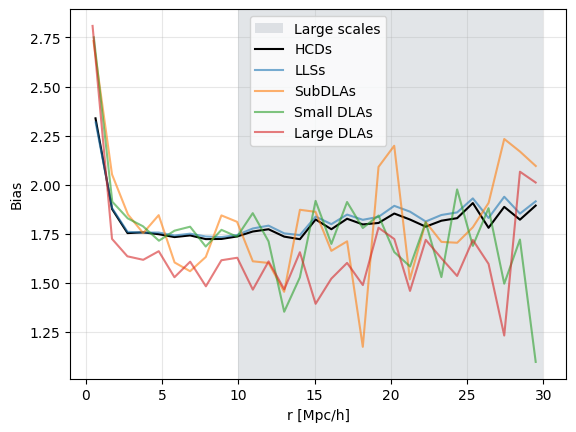

In [16]:
plt.axvspan(10, 30, facecolor='slategrey', alpha=0.2, label='Large scales')
plt.plot(corrfunc_hcd['ravg'], bias_hcd, color='k', label='HCDs')
plt.plot(corrfunc_lls['ravg'], bias_lls, alpha=0.6, label='LLSs')
plt.plot(corrfunc_subdla['ravg'], bias_subdla, alpha=0.6, label='SubDLAs')
plt.plot(corrfunc_smalldla['ravg'], bias_smalldla, alpha=0.6, label='Small DLAs')
plt.plot(corrfunc_largedla['ravg'], bias_largedla, alpha=0.6, label='Large DLAs')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'Bias')
plt.grid(alpha=0.3)
plt.legend();

In [17]:
mask = (corrfunc_hcd['ravg'] > 10)

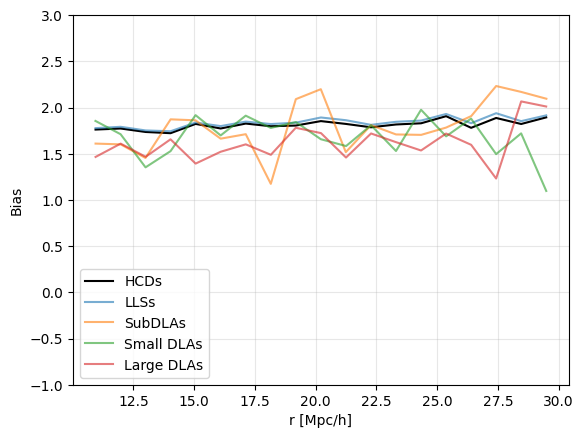

In [18]:
plt.plot(corrfunc_hcd['ravg'][mask], bias_hcd[mask], color='k', label='HCDs')
plt.plot(corrfunc_lls['ravg'][mask], bias_lls[mask], alpha=0.6, label='LLSs')
plt.plot(corrfunc_subdla['ravg'][mask], bias_subdla[mask], alpha=0.6, label='SubDLAs')
plt.plot(corrfunc_smalldla['ravg'][mask], bias_smalldla[mask], alpha=0.6, label='Small DLAs')
plt.plot(corrfunc_largedla['ravg'][mask], bias_largedla[mask], alpha=0.6, label='Large DLAs')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'Bias')
plt.grid(alpha=0.3)
plt.ylim(-1, 3)
plt.legend();

In [19]:
bias_hcd, bias_hcd_std = np.nanmean(bias_hcd[mask]), np.nanstd(bias_hcd[mask])
bias_lls, bias_lls_std = np.nanmean(bias_lls[mask]), np.nanstd(bias_lls[mask])
bias_subdla, bias_subdla_std = np.nanmean(bias_subdla[mask]), np.nanstd(bias_subdla[mask])
bias_smalldla, bias_smalldla_std = np.nanmean(bias_smalldla[mask]), np.nanstd(bias_smalldla[mask])
bias_largedla, bias_largedla_std = np.nanmean(bias_largedla[mask]), np.nanstd(bias_largedla[mask])
print('HCDs bias=', bias_hcd, '+-', bias_hcd_std)
print('LLSs bias=', bias_lls, '+-', bias_lls_std)
print('Sub-dlas bias=', bias_subdla, '+-', bias_subdla_std)
print('Small DLAs bias=', bias_smalldla, '+-', bias_smalldla_std)
print('Large DLAs bias=', bias_largedla, '+-', bias_largedla_std)

HCDs bias= 1.8111856484624098 +- 0.04873898828414669
LLSs bias= 1.8390609146303727 +- 0.05315677834638494
Sub-dlas bias= 1.7980176538547112 +- 0.2700419402340387
Small DLAs bias= 1.6858185659151192 +- 0.2127713655974928
Large DLAs bias= 1.6140292749946834 +- 0.19458528639062198


## Comparison with Powerspectrum-obtained bias

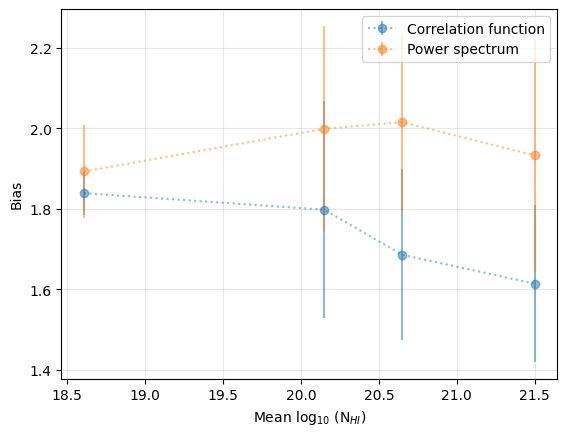

In [20]:
mean_colden = [18.61, 20.15, 20.65, 21.5]
y_corrfunc = [bias_lls, bias_subdla, bias_smalldla, bias_largedla]
yerr_corrfunc = [bias_lls_std, bias_subdla_std, bias_smalldla_std, bias_largedla_std]
y_power = [1.8930029169424774, 1.9991548356076574, 2.015717422434702, 1.9328845762419726]
yerr_power = [0.11637370008979467, 0.2558593387633578, 0.22034125233264856, 0.2888552549084233]
plt.errorbar(mean_colden, y=y_corrfunc, yerr=yerr_corrfunc, linestyle='dotted', marker='o', alpha=0.5, label='Correlation function')
plt.errorbar(mean_colden, y=y_power, yerr=yerr_power, linestyle='dotted', marker='o', alpha=0.5, label='Power spectrum')
plt.xlabel(r'Mean log$_{10}$ (N$_{HI}$)')
plt.ylabel('Bias')
plt.grid(alpha=0.3)
plt.legend();